In [248]:
import pandas as pd
import numpy as np

from tqdm import tqdm

import re
import nltk
# nltk.download('stopwords')
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = list(stopwords.words('english'))

import spacy
nlp = spacy.load("en_core_web_sm", disable=["tagger","parser", "ner"])

from collections import defaultdict

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import recall_score, accuracy_score, classification_report
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance
from sklearn.svm import LinearSVC, SVC

import matplotlib.pyplot as plt
import seaborn as sns

import gensim
from gensim.models import Word2Vec, KeyedVectors

## Import pre-processed data

Write a function to import pre-processed data for modelling. Currently, just reading from a previously saved csv file.


In [2]:
# Clean text
def clean_text(text):

    # remove punctuation
    reg_punc =re.compile(r'[^\w\s]')
    text = reg_punc.sub(r'', text)

    # remove html
    reg_html = re.compile(r'<.*?>')
    text = reg_html.sub(r'', text)

    # remove url
    reg_url = re.compile(r'http\S+')
    text = reg_url.sub(r'', text)

    # remove numerical values
    reg_num = re.compile(r'[0-9]')
    text = reg_num.sub(r'', text)

    # remove special characters
    reg_spcl = re.compile('[@_!#$%^&*()<>?/\\|}{~:]')
    text = reg_spcl.sub(r'', text)

    # remove emoji
    emoji_url = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_url.sub(r'', text)

    return text

In [3]:
data = pd.read_csv("data/dev_data.csv")
data['text'] = data['text'].apply(lambda x: clean_text(x))

emotions = data['label'].unique().tolist()
emotions.sort()
emotions

['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']

In [5]:
X_train,X_test, y_train, y_test = train_test_split(data['text'], data['label'], random_state=0,
                                                   test_size= 0.3, stratify= data['label'])

In [237]:
def preprocess(X, remove_stopwords= False):
    w2v_data = []
    for tt in X:
        if remove_stopwords:
            w2v_data.append([ww for ww in word_tokenize(tt.lower()) if ww not in stop_words])
        else:
            w2v_data.append([ww for ww in word_tokenize(tt.lower())])
    return w2v_data

In [238]:
w2v_train = preprocess(X_train, remove_stopwords= True)
w2v_test = preprocess(X_test, remove_stopwords= True)

model = Word2Vec(w2v_train, min_count = 1, window = 5, vector_size= 300)
model.wv.most_similar('affectionate')

[('hostile', 0.9012235999107361),
 ('considerate', 0.8852538466453552),
 ('compassionate', 0.8849902153015137),
 ('sympathetic', 0.8814210891723633),
 ('unfriendly', 0.873430073261261),
 ('hateful', 0.8694850206375122),
 ('spiteful', 0.8651256561279297),
 ('submissive', 0.8534082174301147),
 ('fond', 0.8379729986190796),
 ('benevolent', 0.8376335501670837)]

In [239]:
goog_wordvecs = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True, limit=100000)
print([key for key, value in goog_wordvecs.key_to_index.items() if 'affection' in key])
goog_wordvecs.most_similar('loving')

['affection', 'affectionate', 'affectionately', 'affections', 'affectionately_known', 'disaffection']


[('caring', 0.6086411476135254),
 ('affectionate', 0.607965886592865),
 ('loved', 0.5888829231262207),
 ('love', 0.5886635780334473),
 ('lovable', 0.5790708065032959),
 ('loveable', 0.57173752784729),
 ('doting', 0.5637443661689758),
 ('compassionate', 0.5366425514221191),
 ('adore', 0.5251007080078125),
 ('hating', 0.5190152525901794)]

In [240]:
# Create a Word2Vec Transformer
class W2VEmbeddings(TransformerMixin):
    def __init__(self, w2v_model= None, weights = None, max_len= None):
        self.w2v_model = w2v_model
        self.weights = weights
        self.word2weight = None

        # add max len parameter
        if max_len is not None:
            self.max_len = max_len
        elif self.w2v_model is not None:
            self.max_len = self.w2v_model.vector_size
        else:
            self.max_len = 100

    def fit(self, X, y=None, **fit_params):
        w2v_X = preprocess(X)

        if self.w2v_model is None:
            print("Fitting new Word2Vec model on training data.")
            w2v_model = Word2Vec(w2v_X, min_count = 1, window = 3, vector_size= 100)
            self.w2v_model = w2v_model.wv
            self.max_len = min(self.max_len,self.w2v_model.vector_size)
            print("Done!")
            
        if self.weights == "idf":
            tfidf = TfidfVectorizer(analyzer= lambda x: x)
            tfidf.fit(w2v_X)
            # if a word was never seen - it must be at least as infrequent as any of the known words
            # so the default idf is the max of known idf's
            max_idf = max(tfidf.idf_)
            self.word2weight = defaultdict(
                lambda: max_idf,
                [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
            print("Fit the IDF Model")
        else:
            self.word2weight = defaultdict(lambda: 1)
        return self
    
    def transform(self, X, y=None, **fit_params):
        X_w2v = []
        for vv in preprocess(X):
            X_w2v.append(np.mean([self.w2v_model[w][:self.max_len] * self.word2weight[w] for w in vv 
                    if w in self.w2v_model.key_to_index.keys()] 
                    or [np.zeros(self.max_len)], axis= 0))
        return X_w2v


Fit the IDF Model
Fit the IDF Model


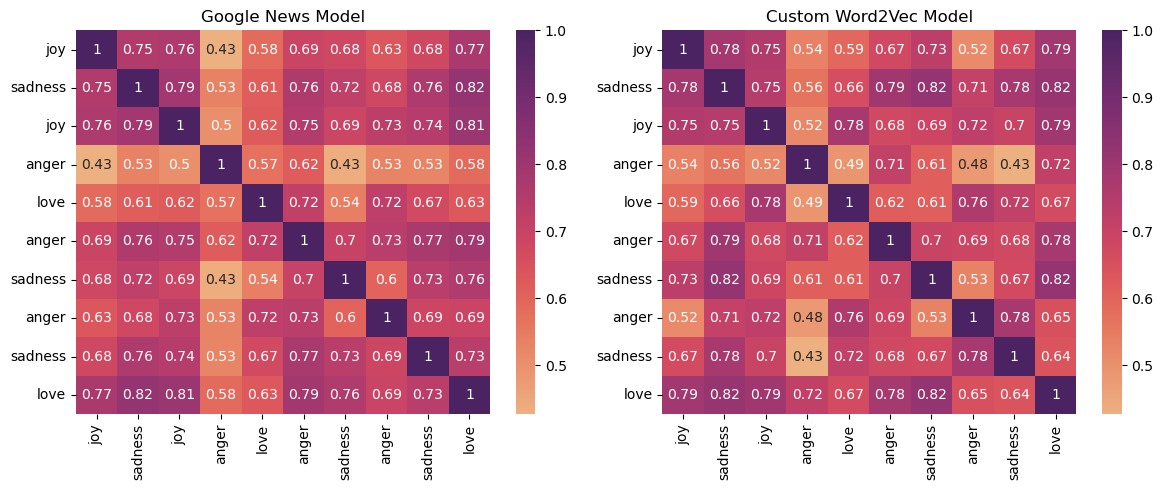

In [241]:
fig,axs = plt.subplots(figsize= (12,5), ncols= 2)

test_goog = W2VEmbeddings(weights= 'idf', w2v_model= goog_wordvecs, max_len= 300).fit_transform(X_train[:10])
sns.heatmap(pd.DataFrame(cosine_similarity(test_goog), index = y_train[:10], columns= y_train[:10]), annot= True,
            cmap= sns.color_palette("flare", as_cmap=True), ax= axs[0])
axs[0].set_xlabel('')
axs[0].set_ylabel('')
axs[0].set_title("Google News Model")

test_custom = W2VEmbeddings(weights= 'idf', w2v_model= model.wv).fit_transform(X_train[:10])
sns.heatmap(pd.DataFrame(cosine_similarity(test_custom), index = y_train[:10], columns= y_train[:10]), annot= True,
            cmap= sns.color_palette("flare", as_cmap=True), ax= axs[1])
axs[1].set_xlabel('')
axs[1].set_ylabel('')
axs[1].set_title("Custom Word2Vec Model")

plt.tight_layout();



In [246]:
pipe_svm = Pipeline([
    ('w2v', W2VEmbeddings(weights= 'idf', w2v_model= model.wv, max_len= 200)),
    ('svc', SGDClassifier(loss= 'hinge'))
])
svm_grid = GridSearchCV(pipe_svm, cv= 3, scoring= 'accuracy', param_grid= {'svc__alpha':[0.001, 0.01]}, verbose= 1)
%time pipe_svm.fit(X_train, y_train)
# print(svm_grid.best_params_)

%time y_pred = pipe_svm.predict(X_test)

print(f"SVM accuracy is: {accuracy_score(y_test, y_pred):0.2f}.\n")
print(classification_report(y_test, y_pred))

Fit the IDF Model
CPU times: total: 1min 3s
Wall time: 1min 15s
CPU times: total: 10.9 s
Wall time: 12.9 s
SVM accuracy is: 0.66.

              precision    recall  f1-score   support

       anger       0.66      0.47      0.55     13889
        fear       0.62      0.52      0.57     11776
         joy       0.66      0.91      0.76     33625
        love       0.80      0.09      0.16      8144
     sadness       0.66      0.74      0.70     28916
    surprise       0.62      0.13      0.21      3530

    accuracy                           0.66     99880
   macro avg       0.67      0.48      0.49     99880
weighted avg       0.67      0.66      0.62     99880



In [250]:
pipe_knn = Pipeline([
    ('w2v', W2VEmbeddings(weights= None, w2v_model= model.wv)),
    ('knn', KNeighborsClassifier(n_neighbors= 20, metric= 'cosine', weights= 'distance'))
])
knn_grid = GridSearchCV(pipe_knn, cv= 3, scoring= 'accuracy', param_grid= {'knn__n_neighbors':[10,20,50,100]}, verbose= 1)
%time knn_grid.fit(X_train[:50000], y_train.head(50000))
print(knn_grid.best_params_)

y_pred = knn_grid.predict(X_test)
print(f"KNN classification accuracy is: {accuracy_score(y_test, y_pred):0.2f}.\n")
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 4 candidates, totalling 12 fits
CPU times: total: 8min 13s
Wall time: 4min 41s
{'knn__n_neighbors': 50}
KNN classification accuracy is: 0.57.

              precision    recall  f1-score   support

       anger       0.59      0.21      0.31     13889
        fear       0.57      0.21      0.31     11776
         joy       0.62      0.83      0.71     33625
        love       0.59      0.14      0.23      8144
     sadness       0.51      0.77      0.62     28916
    surprise       0.46      0.06      0.11      3530

    accuracy                           0.57     99880
   macro avg       0.56      0.37      0.38     99880
weighted avg       0.57      0.57      0.52     99880



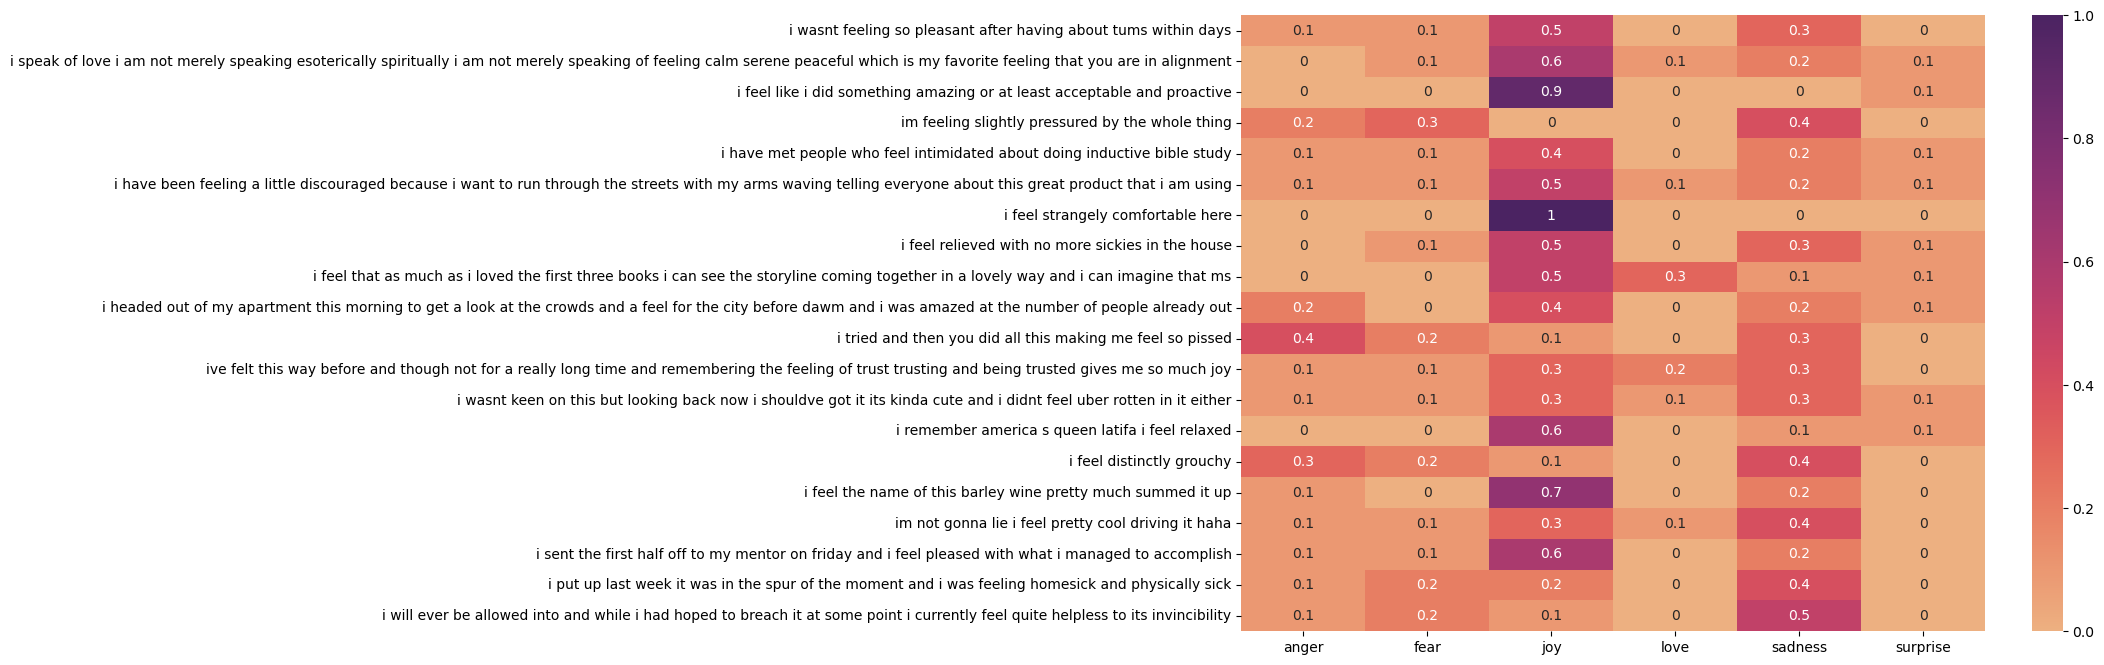

In [275]:
plt.figure(figsize=(12,8))
sns.heatmap(pd.DataFrame(np.round(knn_grid.predict_proba(X_test[:20]),1), index= X_test[:20], columns= knn_grid.classes_), annot= True,
            cmap= sns.color_palette("flare", as_cmap=True))
plt.ylabel('');

In [280]:
pipe_svm.predict(["care about him much", "i want to spend the rest of my life with the man that i love"])

array(['sadness', 'sadness'], dtype='<U8')